<a href="https://colab.research.google.com/github/tengkukevin/bert-cnn/blob/main/ROBERTA-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisialisasi

In [8]:
from transformers import RobertaTokenizer
import tensorflow as tf
from transformers import TFRobertaModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [9]:
# Baca dataset CSV
# Dataset menggunakan ISEAR
# Download dari https://www.kaggle.com/datasets/juanchristopheryoung/isear-dataset
df = pd.read_csv('https://raw.githubusercontent.com/tengkukevin/bert-cnn/refs/heads/main/isear.csv')

# Kolom pertama adalah label, kolom kedua adalah teks
labels = df.iloc[:, 0]
texts = df.iloc[:, 1]

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize teks menggunakan tokenizer ROBERTA
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
inputs = tokenizer(texts.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=128)

# Setting parameter disini
learning_rate = 4e-5
epoch = 50
batch_size = 16
dropout_rate = 0.5

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# Ubah label ke bentuk one-hot encoding
encoded_labels = to_categorical(encoded_labels)

# Convert Tensor ke Numpy array
input_ids = np.array(inputs['input_ids'])
attention_mask = np.array(inputs['attention_mask'])

# Bagi dataset menjadi data train dan validation
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, encoded_labels, test_size=0.2, random_state=42
)

# Proses Training

In [11]:
class RobertaCNNEmotionModel(tf.keras.Model):
    def __init__(self, roberta_model_name='roberta-base', num_classes=3, dropout_rate=0.3):
        super(RobertaCNNEmotionModel, self).__init__()
        self.roberta = TFRobertaModel.from_pretrained(roberta_model_name)
        self.conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')
        self.pool1 = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training = False):
        roberta_output = self.roberta(inputs)[0]  # Take the last hidden state (sequence output)
        conv_output = self.conv1(roberta_output)
        pooled_output = self.pool1(conv_output)
        dropout_output = self.dropout(pooled_output, training=training)
        return self.dense(dropout_output)

In [12]:
# Inisialisasi model RoBERTa-CNN
model = RobertaCNNEmotionModel(num_classes=len(label_encoder.classes_), dropout_rate=dropout_rate)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Latih model
history = model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epoch, batch_size=batch_size)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 36s 98ms/step - accuracy: 0.3547 - loss: 1.3829 - precision_1: 0.3582 - recall_1: 0.2625 - val_accuracy: 0.4947 - val_loss: 1.0246 - val_precision_1: 0.8269 - val_recall_1: 0.0654
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4100 - loss: 1.1831 - precision_1: 0.4341 - recall_1: 0.2887 - val_accuracy: 0.5358 - val_loss: 0.9727 - val_precision_1: 0.8878 - val_recall_1: 0.1324
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4489 - loss: 1.1044 - precision_1: 0.4880 - recall_1: 0.2799 - val_accuracy: 0.6210 - val_loss: 0.9317 - val_precision_1: 0.8528 - val_recall_1: 0.2116
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5058 - loss: 0.9922 - precision_1: 0.5936 - recall_1: 0.3435 - val_accuracy: 0.6423 - val_loss: 0.8929 - val_precision_1: 0.8706 - val_recall_1: 0.2664
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5769 - loss: 0.9062 - precision_1: 0.6718 - recall_1: 0.

# Evaluasi

In [13]:
# Evaluasi pada data validasi
model.evaluate(val_inputs, val_labels)

# Prediksi label
y_pred = model.predict(val_inputs)

# Ambil label dengan probabilitas tertinggi (argmax)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(val_labels, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.8214 - loss: 0.4449 - precision_1: 0.8749 - recall_1: 0.7896
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step
Precision: 0.820971484661063
Recall: 0.8188736681887366
F1-Score: 0.8192440132191817


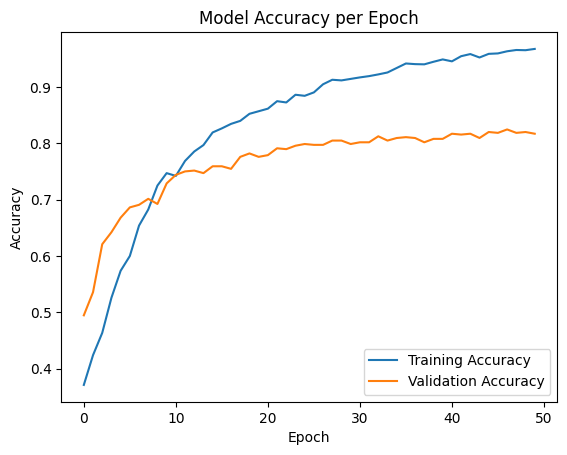

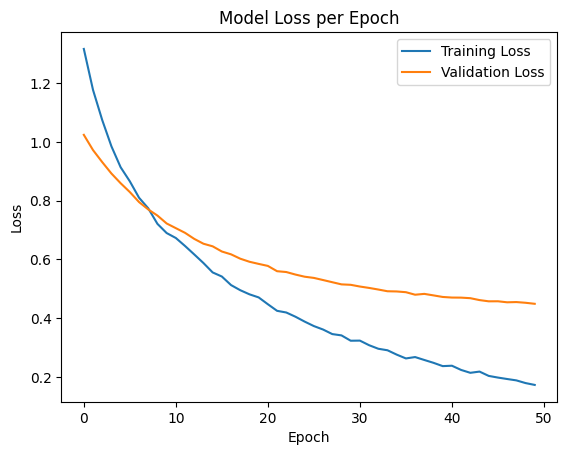

In [14]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Testing

In [24]:
# Prediksi emosi pada teks baru
new_texts = ["why this is happening to me", "I deserve to be treated with respect, but you constantly belittle and demean me.", "I'm tired of feeling invisible in our relationship. It's time to have a conversation about the neglect I've been experiencing."]
new_inputs = tokenizer(new_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)

predictions = model.predict(new_inputs['input_ids'])
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
['sad' 'angry' 'angry']
